In [1]:
pip install pandas  matplotlib scikit-learn scipy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 12.2 MB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 9.2 MB 73.0 MB/s eta 0:00:01
     |████████████████████████████████| 9.8 MB 56.6 MB/s eta 0:00:01
     |████████████████████████████████| 34.5 MB 90.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 55.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 70.2 MB/s eta 0:00:01
     |████████████████████████████████| 300 kB 74.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 73.7 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 72.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import time
import pandas as pd
import numpy as np
import h5py
import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from itertools import islice
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.activations import softmax
from keras.activations import relu
import gc
import itertools
from sklearn.metrics import mean_squared_error
import sklearn
from numpy import genfromtxt
from os import listdir
from os.path import isfile, join
import os
import copy
from scipy import interpolate
from scipy.spatial import distance
import time
import numpy as np

#np.set_printoptions(suppress=True)


def load_dataset(datasets,shape,labels):
    start = time.time()
    count = 1
    wavelength_list = []
    intensity_list = []
    label_list = []
    get_wavelength = True
    for dataset_name in datasets:
        with h5py.File(dataset_name, "r") as f:
            if get_wavelength: wavelengths = np.array(np.split(f['wavelength'][:], f['wavelength'][:].shape[0]//shape))
            intensities = np.array(np.split(f['intensity'][:], f['intensity'][:].shape[0]//shape))
            labels = np.array(np.split(f['label'][:], f['label'][:].shape[0]//labels))/100
            if get_wavelength: wavelength_list.append(wavelengths)
            intensity_list.append(intensities)
            label_list.append(labels)
            print(dataset_name, " Done")
        get_wavelength = False
    wavelengths = np.array(list(itertools.chain.from_iterable(wavelength_list)))
    intensities = np.array(list(itertools.chain.from_iterable(intensity_list)))
    labels = np.array(list(itertools.chain.from_iterable(label_list)))
    print(round(time.time()-start,2), "seconds")    
    return wavelengths, intensities, labels


## read whole dataset

In [3]:
datasets_to_load = ['dataset7.h5']
wavelengths_list, c, labels_list = load_dataset(datasets_to_load,4094,24)
current_elements = ['C', 'Mg', 'Al', 'Si', 'Ti', 'V', 'Fe', 'Co', 'Ni', 'Cu', 'Mn', 'Li', 'Zn', 'O', 'P', 'Pt', 'Au', 'Ag', 'Ir', 'W', 'Pd', 'Sn', 'Tc', 'Y']

dataset7.h5  Done
40.88 seconds


In [4]:
df_wavelengths=pd.DataFrame(wavelengths_list)
df_wavelengths.shape

(53660, 4094)

In [5]:
df_intensity=pd.DataFrame(c)
df_intensity.shape

(53660, 4094)

In [6]:
df_labels_list=pd.DataFrame(labels_list)
df_labels_list.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Remove gas elements

In [7]:
df_labels_list[13]!=0.0

0        False
1        False
2        False
3        False
4        False
         ...  
53655    False
53656    False
53657    False
53658    False
53659    False
Name: 13, Length: 53660, dtype: bool

In [8]:
#row 13 is 'O' which is gas element so droping all the rows which has oxygen
#get rows with gas elements .i.e. rows which has value other than 0 in column 13
rows_gas = df_labels_list[(df_labels_list[[13]] != 0.0).all(axis=1)]
rows_gas

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
13,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
36,0.99,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
58,0.00,0.99,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
79,0.00,0.00,0.99,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
99,0.00,0.00,0.00,0.99,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53535,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.00,0.30,0.0
53536,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.00,0.00,0.3
53537,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.15,0.30,0.0
53538,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.15,0.00,0.3


In [9]:
rows_of_gas=rows_gas.index
rows_of_gas

Int64Index([   13,    36,    58,    79,    99,   118,   136,   153,   169,
              184,
            ...
            53530, 53531, 53532, 53533, 53534, 53535, 53536, 53537, 53538,
            53539],
           dtype='int64', length=5567)

In [10]:

df_intensity=df_intensity.drop(index=rows_of_gas)
df_intensity.shape

(48093, 4094)

In [11]:
df_wavelengths=df_wavelengths.drop(index=rows_of_gas)
df_wavelengths.shape

(48093, 4094)

In [12]:
df_labels_list=df_labels_list.drop(index=rows_of_gas)
df_labels_list.shape


(48093, 24)

In [13]:
df_labels_list=df_labels_list.drop(13, axis=1)
df_labels_list.shape

(48093, 23)

### Removing more elements ('Mn', 'Li', 'Zn', 'P', 'Pt', 'Au', 'Ag', 'Ir', 'W', 'Pd', 'Sn', 'Tc', 'Y')

In [ ]:
#Mn
#read rows with values in it
Mn_rows = df_labels_list[(df_labels_list[[10]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Mn=Mn_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Mn)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Mn)

In [14]:
df_labels_list=df_labels_list.drop(10, axis=1)
df_labels_list.shape

(42911, 22)

In [15]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (42911, 4094)
Shape of df_labels_list : (42911, 22)


In [16]:
#Li
#read rows with values in it
Li_rows = df_labels_list[(df_labels_list[[11]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Li=Li_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Li)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Li)

In [17]:
df_labels_list=df_labels_list.drop(11, axis=1)
df_labels_list.shape

(38101, 21)

In [18]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (38101, 4094)
Shape of df_labels_list : (38101, 21)


In [19]:
#Zn
#read rows with values in it
Zn_rows = df_labels_list[(df_labels_list[[12]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Zn=Zn_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Zn)
#drop those rows from labels dataframe
df_labels_list=df_labnextels_list.drop(index=rows_of_Zn)

In [20]:
df_labels_list=df_labels_list.drop(12, axis=1)
df_labels_list.shape

(33650, 20)

In [21]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (33650, 4094)
Shape of df_labels_list : (33650, 20)


In [24]:
#P
#read rows with values in it
P_rows = df_labels_list[(df_labels_list[[14]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_P=P_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_P)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_P)

In [25]:
df_labels_list=df_labels_list.drop(14, axis=1)
df_labels_list.shape

(29545, 19)

In [26]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (29545, 4094)
Shape of df_labels_list : (29545, 19)


In [27]:
#Pt
#read rows with values in it
Pt_rows = df_labels_list[(df_labels_list[[15]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Pt=Pt_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Pt)
#drop those rows from labels dataframe
df_labels_list=df_labnextels_list.drop(index=rows_of_Pt)

In [28]:
df_labels_list=df_labels_list.drop(15, axis=1)
df_labels_list.shape

(25773, 18)

In [29]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (25773, 4094)
Shape of df_labels_list : (25773, 18)


In [30]:
#Au
#read rows with values in it
Au_rows = df_labels_list[(df_labels_list[[16]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Au=Au_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Au)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Au)

In [31]:
df_labels_list=df_labels_list.drop(16, axis=1)
df_labels_list.shape

(22321, 17)

In [32]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (22321, 4094)
Shape of df_labels_list : (22321, 17)


In [33]:
#Ag
#read rows with values in it
Ag_rows = df_labels_list[(df_labels_list[[17]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Ag=Ag_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Ag)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Ag)

In [34]:
df_labels_list=df_labels_list.drop(17, axis=1)
df_labels_list.shape

(19176, 16)

In [35]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (19176, 4094)
Shape of df_labels_list : (19176, 16)


In [36]:
#Ir
#read rows with values in it
Ir_rows = df_labels_list[(df_labels_list[[18]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Ir=Ir_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Ir)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Ir)

In [37]:
df_labels_list=df_labels_list.drop(18, axis=1)
df_labels_list.shape

(16325, 15)

In [38]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (16325, 4094)
Shape of df_labels_list : (16325, 15)


In [39]:
#W
#read rows with values in it
W_rows = df_labels_list[(df_labels_list[[19]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_W=W_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_W)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_W)

In [40]:
df_labels_list=df_labels_list.drop(19, axis=1)
df_labels_list.shape

(13755, 14)

In [41]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (13755, 4094)
Shape of df_labels_list : (13755, 14)


In [40]:
#Pd
#read rows with values in it
Pd_rows = df_labels_list[(df_labels_list[[20]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Pd=Pd_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Pd)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Pd)

In [41]:
df_labels_list=df_labels_list.drop(20, axis=1)
df_labels_list.shape

(11453, 13)

In [42]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (11453, 4094)
Shape of df_labels_list : (11453, 13)


In [43]:
#Sn
#read rows with values in it
Sn_rows = df_labels_list[(df_labels_list[[21]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Sn=Sn_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Sn)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Sn)

In [44]:
df_labels_list=df_labels_list.drop(21, axis=1)
df_labels_list.shape

(9406, 12)

In [45]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (9406, 4094)
Shape of df_labels_list : (9406, 12)


In [46]:
#Tc
#read rows with values in it
Tc_rows = df_labels_list[(df_labels_list[[22]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Tc=Tc_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Tc)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Tc)

In [47]:
df_labels_list=df_labels_list.drop(22, axis=1)
df_labels_list.shape

(7601, 11)

In [48]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (7601, 4094)
Shape of df_labels_list : (7601, 11)


In [49]:
#Y
#read rows with values in it
Y_rows = df_labels_list[(df_labels_list[[23]] != 0.0).all(axis=1)]
#get index values of rows
rows_of_Y=Y_rows.index
#drop those rows from intensity dataframe
df_intensity=df_intensity.drop(index=rows_of_Y)
#drop those rows from labels dataframe
df_labels_list=df_labels_list.drop(index=rows_of_Y)

In [50]:
df_labels_list=df_labels_list.drop(23, axis=1)
df_labels_list.shape

(6025, 10)

In [51]:
print("Shape of df_intensity :", df_intensity.shape)
print("Shape of df_labels_list :", df_labels_list.shape)

Shape of df_intensity : (6025, 4094)
Shape of df_labels_list : (6025, 10)


## normalize the dataset (sampel)

In [14]:
norm_row_wise = preprocessing.normalize(df_intensity, axis=0)
df_intensity_norm = pd.DataFrame(norm_row_wise)

In [15]:
#reset the index
df_intensity_norm.reset_index(drop=True, inplace=True)
df_labels_list.reset_index(drop=True, inplace=True)

In [16]:
df_labels_list.shape

(48093, 23)

## split dataset for train set and test set

In [17]:
x=df_intensity_norm
y=df_labels_list

In [18]:
# Split x into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [19]:
# Print the shape of the resulting data sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (43283, 4094)
y_train shape: (43283, 23)
X_test shape: (4810, 4094)
y_test shape: (4810, 23)


In [20]:
from tensorflow.keras.layers import Dropout

In [29]:
# Compile the model
def create_model(my_learning_rate):
    model = tf.keras.models.Sequential()
    #model.add(Dense(30048, batch_input_shape=(None,4094), activation=relu,name="layer_1"))
    #model.add(Dense(25048, batch_input_shape=(None,4094), activation=relu,name="layer_8"))
    #model.add(Dense(20000, batch_input_shape=(None,4094), activation=relu,name="layer_2")) 
    model.add(Dense(10000, batch_input_shape=(None,4094), activation=relu,name="layer_1"))
    model.add(Dropout(0.2))
    model.add(Dense(5000, batch_input_shape=(None,4094), activation=relu,name="layer_2"))
    model.add(Dropout(0.2))
    model.add(Dense(1024, batch_input_shape=(None,4094), activation=relu,name="layer_3"))
    model.add(Dropout(0.2))
    model.add(Dense(512, batch_input_shape=(None,4094), activation=relu,name="layer_4"))
    model.add(Dense(256, batch_input_shape=(None,4094), activation=relu,name="layer_5"))   
    model.add(Dense(128, batch_input_shape=(None,4094), activation=relu,name="layer_6"))
    model.add(Dense(23, activation=softmax,name="output"))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=my_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model 


In [30]:
# Train the model
def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.2):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=2,
                      validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist    

In [48]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 1000
batch_size = 80
validation_split = 0.3


In [49]:
# Establish the model's topography.
my_model = create_model(learning_rate)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, X_train, y_train, epochs, batch_size, validation_split)

Epoch 1/1000
379/379 - 6s - loss: 1.1880 - accuracy: 0.7891 - val_loss: 0.8991 - val_accuracy: 0.8105 - 6s/epoch - 15ms/step
Epoch 2/1000
379/379 - 4s - loss: 0.8585 - accuracy: 0.8187 - val_loss: 0.8136 - val_accuracy: 0.8241 - 4s/epoch - 12ms/step
Epoch 3/1000
379/379 - 5s - loss: 0.8152 - accuracy: 0.8168 - val_loss: 0.7779 - val_accuracy: 0.8446 - 5s/epoch - 12ms/step
Epoch 4/1000
379/379 - 5s - loss: 0.7938 - accuracy: 0.8229 - val_loss: 0.7643 - val_accuracy: 0.8369 - 5s/epoch - 12ms/step
Epoch 5/1000
379/379 - 5s - loss: 0.7799 - accuracy: 0.8346 - val_loss: 0.7534 - val_accuracy: 0.8353 - 5s/epoch - 12ms/step
Epoch 6/1000
379/379 - 4s - loss: 0.7717 - accuracy: 0.8359 - val_loss: 0.7593 - val_accuracy: 0.8445 - 4s/epoch - 12ms/step
Epoch 7/1000
379/379 - 5s - loss: 0.7609 - accuracy: 0.8445 - val_loss: 0.7404 - val_accuracy: 0.8588 - 5s/epoch - 12ms/step
Epoch 8/1000
379/379 - 4s - loss: 0.7527 - accuracy: 0.8565 - val_loss: 0.7426 - val_accuracy: 0.8678 - 4s/epoch - 12ms/step


## epochs= 1000 lr=0.001 batch=80 hidden layer=6 with dropouts and validation split = 0.3

In [50]:
#epochs= 1000 lr=0.001 batch=80 hidden layer= 6 validation split = 0.3 with dropouts
my_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 10000)             40950000  
                                                                 
 dropout_9 (Dropout)         (None, 10000)             0         
                                                                 
 layer_2 (Dense)             (None, 5000)              50005000  
                                                                 
 dropout_10 (Dropout)        (None, 5000)              0         
                                                                 
 layer_3 (Dense)             (None, 1024)              5121024   
                                                                 
 dropout_11 (Dropout)        (None, 1024)              0         
                                                                 
 layer_4 (Dense)             (None, 512)              

In [51]:
#epochs= 1000 lr=0.001 batch=80 hidden layer= 6 validation split = 0.3 withdropouts
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)


 Evaluate the new model against the test set:
542/542 [==============================] - 2s 4ms/step - loss: 0.7083 - accuracy: 0.9053


[0.7082878947257996, 0.9052745699882507]

Text(0.5, 1.0, 'epochs= 1000 lr=0.001 batch=80 hidden layer=6 validation split = 0.3 with dropouts')

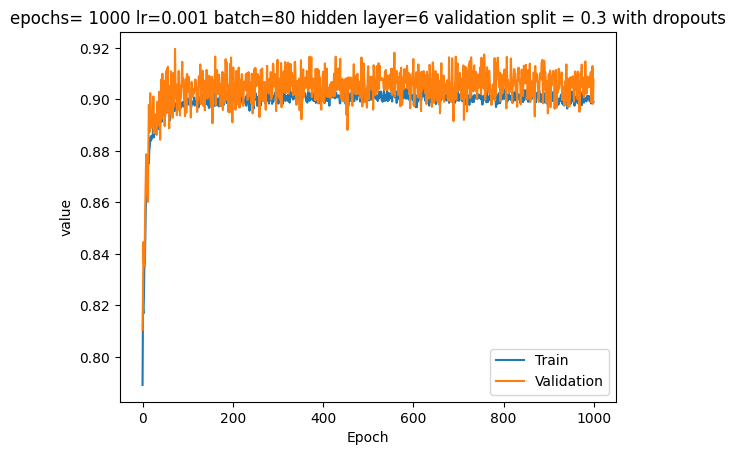

In [52]:
#epochs= 1000 lr=0.001 batch=80 hidden layer= 6 validation split = 0.3 with dropouts
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title("epochs= 1000 lr=0.001 batch=80 hidden layer=6 validation split = 0.3 with dropouts")

## epochs= 1000 lr=0.001 batch=128 hidden layer=6 with dropouts and validation split = 0.3

In [43]:
#epochs= 1000 lr=0.001 batch=128 hidden layer= 6 validation split = 0.3 with dropouts
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 10000)             40950000  
                                                                 
 dropout_3 (Dropout)         (None, 10000)             0         
                                                                 
 layer_2 (Dense)             (None, 5000)              50005000  
                                                                 
 dropout_4 (Dropout)         (None, 5000)              0         
                                                                 
 layer_3 (Dense)             (None, 1024)              5121024   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 layer_4 (Dense)             (None, 512)              

In [44]:
#epochs= 1000 lr=0.001 batch=128 hidden layer= 6 validation split = 0.3 withdropouts
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)


 Evaluate the new model against the test set:
339/339 [==============================] - 2s 5ms/step - loss: 0.7070 - accuracy: 0.8995


[0.7070012092590332, 0.8994755148887634]

Text(0.5, 1.0, 'epochs= 1000 lr=0.001 batch=128 hidden layer=6 validation split = 0.3 with dropouts')

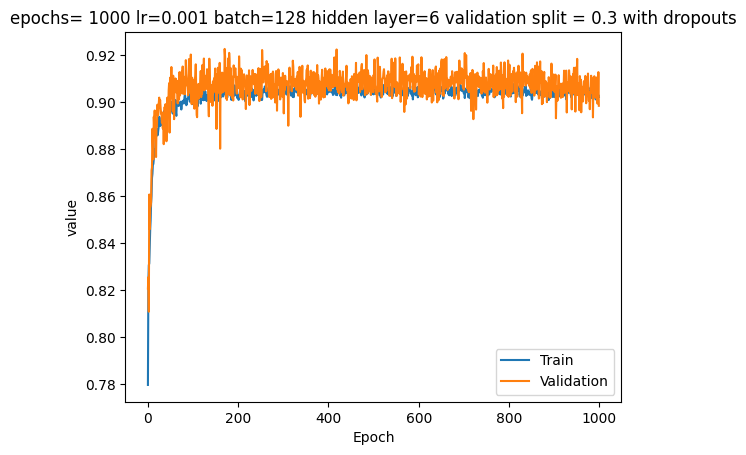

In [45]:
#epochs= 1000 lr=0.001 batch=128 hidden layer= 6 validation split = 0.3 with dropouts
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title("epochs= 1000 lr=0.001 batch=128 hidden layer=6 validation split = 0.3 with dropouts")

## epochs= 1000 lr=0.001 batch=128 hidden layer=6 with dropouts

In [35]:
#epochs= 1000 lr=0.001 batch=128 hidden layer= 6 with dropouts
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 10000)             40950000  
                                                                 
 dropout (Dropout)           (None, 10000)             0         
                                                                 
 layer_2 (Dense)             (None, 5000)              50005000  
                                                                 
 dropout_1 (Dropout)         (None, 5000)              0         
                                                                 
 layer_3 (Dense)             (None, 1024)              5121024   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 layer_4 (Dense)             (None, 512)              

In [39]:
#epochs= 1000 lr=0.001 batch=128 hidden layer= 6 validation split = 0.2 with dropouts
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)


 Evaluate the new model against the test set:
339/339 [==============================] - 2s 5ms/step - loss: 0.7060 - accuracy: 0.9035


[0.7060137987136841, 0.9034956097602844]

Text(0.5, 1.0, 'epochs= 1000 lr=0.001 batch=128 hidden layer=6 validation split = 0.2 with dropouts')

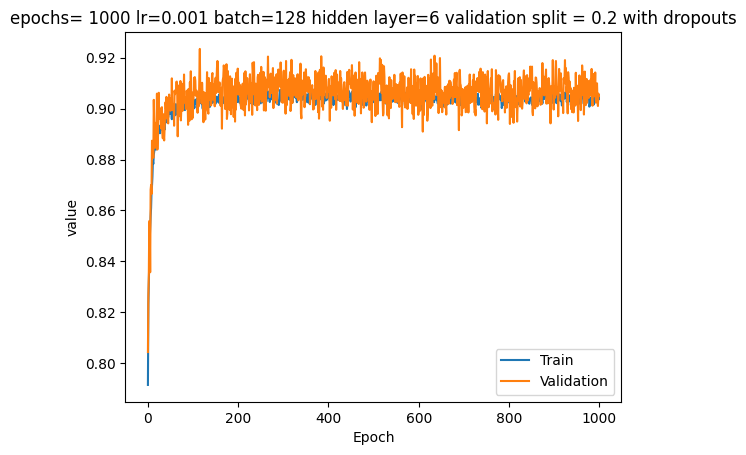

In [40]:
#epochs= 1000 lr=0.001 batch=128 hidden layer= 6 validation split = 0.2 with dropouts
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title("epochs= 1000 lr=0.001 batch=128 hidden layer=6 validation split = 0.2 with dropouts")

## epochs= 1000 lr=0.001 batch=128 hidden layer=6 

In [25]:
#epochs= 1000 lr=0.001 batch=128 hidden layer= 6 
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 10000)             40950000  
                                                                 
 layer_2 (Dense)             (None, 5000)              50005000  
                                                                 
 layer_3 (Dense)             (None, 1024)              5121024   
                                                                 
 layer_4 (Dense)             (None, 512)               524800    
                                                                 
 layer_5 (Dense)             (None, 256)               131328    
                                                                 
 layer_6 (Dense)             (None, 128)               32896     
                                                                 
 output (Dense)              (None, 23)                2

In [26]:
#epochs= 1000 lr=0.001 batch=128 hidden layer= 6
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)


 Evaluate the new model against the test set:
339/339 [==============================] - 2s 5ms/step - loss: 0.7062 - accuracy: 0.9152


[0.7062358260154724, 0.9152323007583618]

Text(0.5, 1.0, 'epochs= 1000 lr=0.001 batch=16 hidden layer=6')

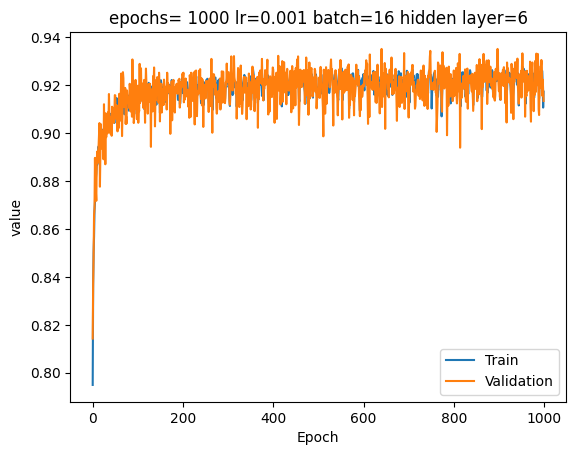

In [27]:
#epochs= 1000 lr=0.001 batch=128 hidden layer= 6 
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title("epochs= 1000 lr=0.001 batch=16 hidden layer=6") #batch0128

## epochs= 500 lr=0.001 batch=16 hidden layer=6 with dropouts

In [33]:
#epochs= 500 lr=0.001 batch=16 hidden layer= 6 with dropout
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 10000)             40950000  
                                                                 
 dropout (Dropout)           (None, 10000)             0         
                                                                 
 layer_2 (Dense)             (None, 5000)              50005000  
                                                                 
 dropout_1 (Dropout)         (None, 5000)              0         
                                                                 
 layer_3 (Dense)             (None, 1024)              5121024   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 layer_4 (Dense)             (None, 512)              

In [34]:
#epochs= 500 lr=0.001 batch=14 hidden layer= 6
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)


 Evaluate the new model against the test set:
2706/2706 [==============================] - 8s 3ms/step - loss: 0.7299 - accuracy: 0.8824


[0.7298849821090698, 0.8823787569999695]

Text(0.5, 1.0, 'epochs= 1000 lr=0.001 batch=16 hidden layer=6')

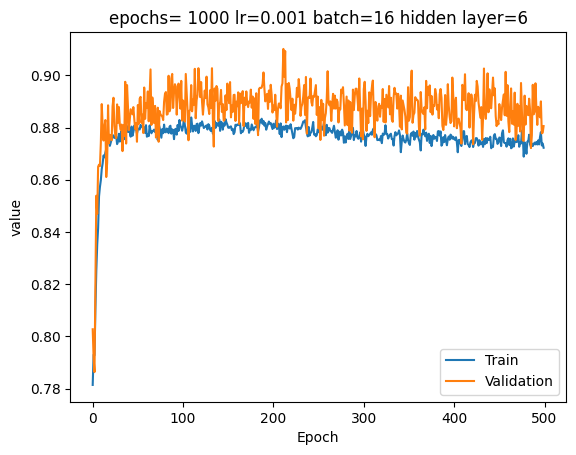

In [35]:
#epochs= 500 lr=0.001 batch=16 hidden layer= 6 with dropout
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title("epochs= 1000 lr=0.001 batch=16 hidden layer=6")

## epochs= 1000 lr=0.001 batch=16 hidden layer=6

In [26]:
#epochs= 1000 lr=0.001 batch=14 hidden layer= 6
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 10000)             40950000  
                                                                 
 layer_2 (Dense)             (None, 5000)              50005000  
                                                                 
 layer_3 (Dense)             (None, 1024)              5121024   
                                                                 
 layer_4 (Dense)             (None, 512)               524800    
                                                                 
 layer_5 (Dense)             (None, 256)               131328    
                                                                 
 layer_6 (Dense)             (None, 128)               32896     
                                                                 
 output (Dense)              (None, 23)                2

In [27]:
#epochs= 1000 lr=0.001 batch=14 hidden layer= 6
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)


 Evaluate the new model against the test set:
2706/2706 [==============================] - 8s 3ms/step - loss: 0.8591 - accuracy: 0.7619


[0.8590846061706543, 0.7618926763534546]

Text(0.5, 1.0, 'epochs= 1000 lr=0.001 batch=16 hidden layer=6')

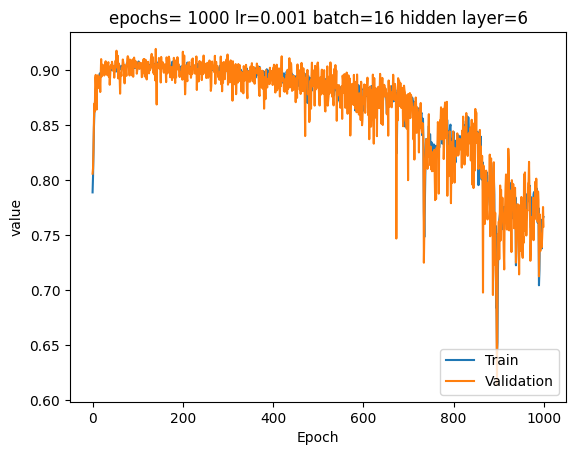

In [28]:
#epoch=1000 lr=0.001 batch=64
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title("epochs= 1000 lr=0.001 batch=16 hidden layer=6")

## epochs= 1000 lr=0.005 batch=64 hidden layer=7

In [25]:
#epochs= 1000 lr=0.005 batch=64
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_2 (Dense)             (None, 20000)             81900000  
                                                                 
 layer_3 (Dense)             (None, 10000)             200010000 
                                                                 
 layer_4 (Dense)             (None, 5000)              50005000  
                                                                 
 layer_5 (Dense)             (None, 1024)              5121024   
                                                                 
 layer_6 (Dense)             (None, 512)               524800    
                                                                 
 layer_7 (Dense)             (None, 256)               131328    
                                                                 
 layer_8 (Dense)             (None, 128)               3

In [26]:
#epoch=1000 lr=0.005 batch=64, elements=23
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)


 Evaluate the new model against the test set:
677/677 [==============================] - 4s 5ms/step - loss: 0.7426 - accuracy: 0.8779


[0.7426409721374512, 0.8778504133224487]

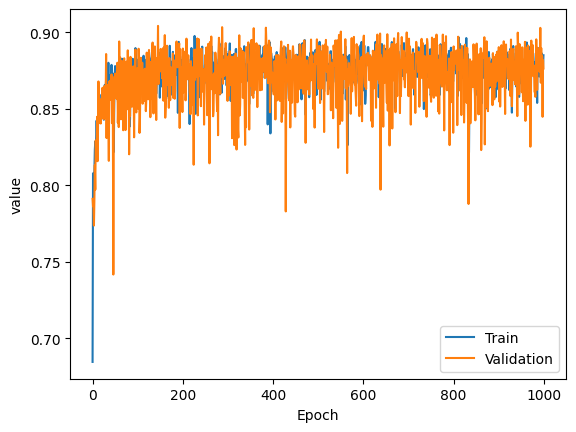

In [27]:
#epoch=500 lr=0.005 batch=64
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

## epoch=1000 lr=0.005 batch=64 with dropout  hidden layer=7

In [32]:
#epochs= 1000 lr=0.005 batch=64 with dropout
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_2 (Dense)             (None, 20000)             81900000  
                                                                 
 layer_3 (Dense)             (None, 10000)             200010000 
                                                                 
 dropout (Dropout)           (None, 10000)             0         
                                                                 
 layer_4 (Dense)             (None, 5000)              50005000  
                                                                 
 dropout_1 (Dropout)         (None, 5000)              0         
                                                                 
 layer_5 (Dense)             (None, 1024)              5121024   
                                                                 
 dropout_2 (Dropout)         (None, 1024)             

In [33]:
#epoch=1000 lr=0.005 batch=64 with dropout
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)


 Evaluate the new model against the test set:
677/677 [==============================] - 4s 5ms/step - loss: 0.7199 - accuracy: 0.8918


[0.7198967337608337, 0.891805112361908]

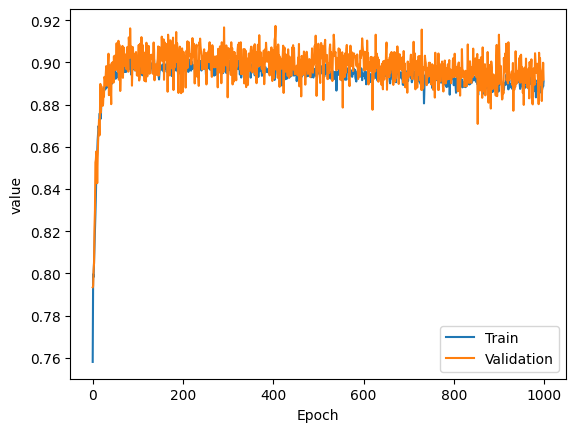

In [34]:
#epoch=1000 lr=0.005 batch=64 with dropout
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

In [23]:
#epochs= 200 lr=0.001 batch=8
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_11 (Dense)            (None, 10024)             41048280  
                                                                 
 layer_15 (Dense)            (None, 1024)              10265600  
                                                                 
 layer_12 (Dense)            (None, 512)               524800    
                                                                 
 layer_13 (Dense)            (None, 256)               131328    
                                                                 
 layer_14 (Dense)            (None, 128)               32896     
                                                                 
 output (Dense)              (None, 23)                2967      
                                                                 
Total params: 52,005,871
Trainable params: 52,005,871
No

In [33]:
#epoch=100 lr=0.001 batch=16, elements=17
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)


 Evaluate the new model against the test set:
677/677 [==============================] - 2s 3ms/step - loss: 0.7053 - accuracy: 0.9156


[0.7053397297859192, 0.9155557751655579]

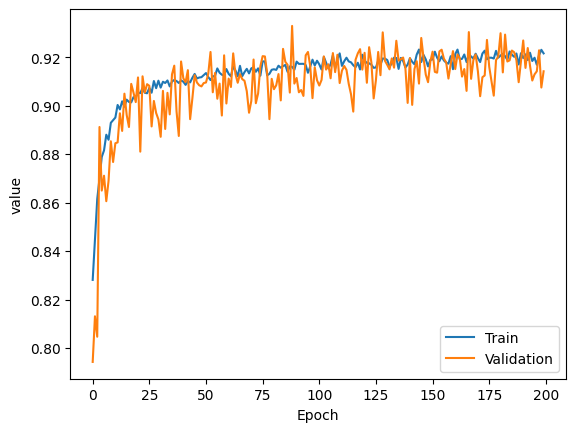

In [34]:
#epoch=500 lr=0.001 batch=64
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title("")

In [47]:
#epoch=100 lr=0.001 batch=16, elements=23
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)


 Evaluate the new model against the test set:
1256/1256 [==============================] - 4s 3ms/step - loss: 0.6759 - accuracy: 0.9212


[0.6759330034255981, 0.9212465286254883]

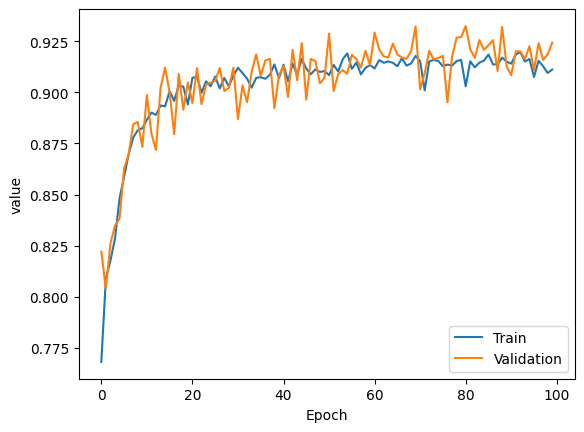

In [48]:
#epoch=500 lr=0.001 batch=64
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

In [ ]:
#epoch=150 lr=0.001 batch=64
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)

In [ ]:
#epoch=150 lr=0.001 batch=64
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

In [ ]:
#epoch=150 lr=0.001 batch=128
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)

In [ ]:
#epoch=150 lr=0.001 batch=128
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

In [69]:
#epoch=200 lr=0.001 batch=128
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_train, y=y_train, batch_size=batch_size)


 Evaluate the new model against the test set:
43/43 [==============================] - 0s 3ms/step - loss: 0.6152 - accuracy: 0.9517


[0.6151790618896484, 0.9516783356666565]

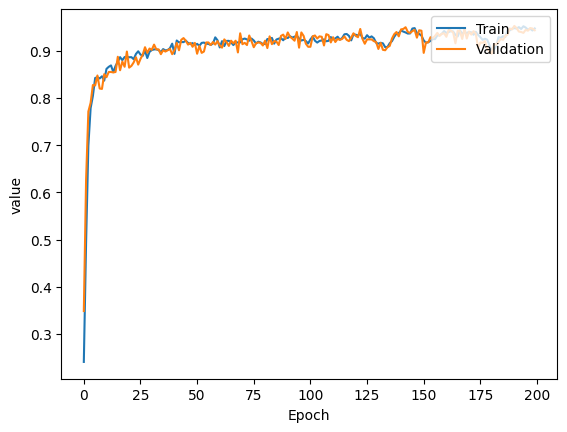

In [70]:
#epoch=200 lr=0.001 batch=128
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Predections

In [76]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093
4365,0.000074,0.000058,2.681079e-05,1.391332e-04,0.000293,4.573984e-04,1.544142e-03,3.118921e-03,3.325489e-03,3.577193e-03,...,2.311855e-09,2.032079e-09,1.780593e-09,1.553766e-09,1.350197e-09,1.168604e-09,1.006851e-09,8.611288e-10,7.279281e-10,6.043189e-10
1129,0.000063,0.000053,2.494403e-05,1.301141e-04,0.000273,4.200537e-04,1.398692e-03,2.791183e-03,2.951664e-03,3.164216e-03,...,2.224197e-27,0.000000e+00,4.928241e-28,5.105656e-28,3.455133e-28,3.768092e-28,3.570041e-28,3.153470e-28,3.151469e-28,4.066027e-28
2602,0.035641,0.024265,9.095846e-03,3.004327e-02,0.031635,2.066345e-02,2.608516e-02,1.763595e-02,5.401663e-03,1.382065e-03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1747,0.051760,0.035247,1.320746e-02,4.360794e-02,0.045834,2.977858e-02,3.718777e-02,2.463352e-02,7.312182e-03,1.788368e-03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3286,0.000286,0.000162,6.179081e-05,2.562264e-04,0.000402,4.372643e-04,9.818200e-04,1.270099e-03,8.588324e-04,6.276918e-04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4840,0.018260,0.028929,1.276400e-02,3.289342e-02,0.023961,1.500739e-02,1.684885e-02,6.381468e-03,6.873884e-04,4.146536e-05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3055,0.000700,0.000435,1.638876e-04,5.640746e-04,0.000615,3.886689e-04,4.223825e-04,2.194385e-04,4.845291e-05,8.901007e-06,...,7.035648e-08,5.950914e-08,4.863943e-08,3.838051e-08,2.921606e-08,2.142948e-08,1.515146e-08,1.032139e-08,6.772616e-09,4.222006e-09
2704,0.000076,0.000058,2.594652e-05,1.292424e-04,0.000256,3.738409e-04,1.184779e-03,2.275214e-03,2.346285e-03,2.486246e-03,...,1.184794e-27,0.000000e+00,2.627992e-28,2.722921e-28,1.843485e-28,2.009601e-28,1.904296e-28,1.682818e-28,1.681710e-28,2.167826e-28
1859,0.000388,0.000294,1.169324e-04,3.934282e-04,0.000387,2.028783e-04,1.688391e-04,6.191696e-05,8.897648e-06,9.657550e-07,...,4.821292e-08,3.969467e-08,3.112460e-08,2.322116e-08,1.647512e-08,1.111744e-08,7.129928e-09,4.347858e-09,2.518437e-09,1.312809e-09


In [49]:
predictions = my_model.predict(X_test)

70/70 [==============================] - 0s 2ms/step


In [50]:
predictions.shape

(2233, 17)

In [52]:
df_predictions = pd.DataFrame(predictions)
df_predictions

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,7.025336e-06,4.627211e-07,3.030113e-06,7.456367e-01,3.577424e-06,1.005812e-07,2.542993e-01,1.981676e-06,1.839410e-06,2.000698e-06,8.592838e-07,9.944365e-07,6.124963e-07,1.459207e-07,1.190260e-07,2.398541e-06,3.882115e-05
1,2.729903e-06,8.643660e-01,3.819681e-07,7.850500e-09,7.794933e-06,1.354173e-01,8.194468e-07,1.114550e-04,2.601103e-07,7.194433e-07,2.210144e-06,5.576425e-05,2.351047e-08,6.130765e-06,1.573979e-06,2.164741e-05,5.219434e-06
2,1.339253e-05,1.220441e-05,5.845406e-05,4.841254e-05,2.509535e-08,1.485548e-01,1.354648e-05,2.731478e-06,2.475556e-07,6.498790e-07,2.774983e-05,4.721972e-05,4.709264e-05,4.807825e-06,4.940528e-06,8.511565e-01,7.131954e-06
3,3.220415e-04,3.793097e-04,2.078408e-05,1.908676e-04,1.643723e-03,7.963375e-03,7.605415e-04,1.486740e-01,5.950214e-03,4.948990e-05,1.330022e-03,3.926390e-04,7.753928e-06,4.881412e-03,5.257624e-04,2.685878e-04,8.266394e-01
4,1.015650e-05,1.128244e-01,8.603329e-05,7.888058e-06,2.835231e-08,1.553280e-07,6.463799e-06,2.192999e-03,8.128232e-09,2.185614e-07,3.628121e-06,4.757262e-09,8.518845e-02,5.479444e-08,1.609513e-10,1.606827e-05,7.996634e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2228,3.986254e-04,3.881530e-06,1.760799e-01,1.363750e-06,1.169283e-06,2.648737e-07,3.393921e-07,7.719531e-07,5.247208e-06,2.486765e-06,8.234886e-01,4.414655e-06,1.928154e-06,9.116608e-06,8.641784e-08,4.101541e-07,1.355536e-06
2229,4.794678e-07,2.777095e-08,3.678693e-06,3.989084e-08,2.251154e-07,2.195548e-08,1.445146e-06,7.893780e-09,6.904481e-11,1.357428e-06,4.547715e-08,1.162983e-01,1.563266e-14,3.558011e-10,7.170017e-10,2.588248e-07,8.836941e-01
2230,2.304574e-01,4.045553e-07,2.288069e-05,3.154310e-06,3.661877e-10,3.368731e-06,4.064682e-08,1.950960e-01,5.743961e-01,2.680116e-08,8.782619e-06,5.294991e-11,3.028021e-07,1.071444e-05,3.902849e-07,2.486079e-08,4.240192e-07
2231,7.928141e-08,4.966529e-01,1.432588e-08,1.743030e-01,2.782938e-08,2.225497e-10,7.757406e-08,9.804802e-12,1.525872e-06,6.239532e-08,3.290334e-01,3.962137e-10,1.896267e-10,9.180440e-07,9.958607e-10,1.692839e-07,7.895531e-06


In [51]:
df_predictions_original = pd.DataFrame(y_test)
df_predictions_original

,0,1,2,3,4,5,6,7,8,9,17,18,19,20,21,22,23
3328,0.0,0.00,0.00,0.75,0.0,0.00,0.25,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00
1940,0.0,0.85,0.00,0.00,0.0,0.15,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00
10840,0.0,0.00,0.00,0.00,0.0,0.20,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.8,0.00
20195,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.1,0.0,0.0,0.00,0.00,0.0,0.00,0.10,0.0,0.80
19819,0.0,0.10,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.1,0.00,0.00,0.0,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11071,0.0,0.00,0.18,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.82,0.00,0.0,0.00,0.00,0.0,0.00
11974,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.12,0.0,0.00,0.00,0.0,0.88
17636,0.2,0.00,0.00,0.00,0.0,0.00,0.00,0.2,0.6,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00
21781,0.0,0.55,0.00,0.15,0.0,0.00,0.00,0.0,0.0,0.0,0.30,0.00,0.0,0.00,0.00,0.0,0.00


In [57]:
#selecting a row from df_intensity for predection
test_1 =df_intensity.iloc[2676]
test_1=pd.DataFrame(test_1)
test_row=test_1.T

In [55]:
df_predictions.iloc[2232]

0     1.223896e-05
1     5.018539e-06
2     2.655084e-08
3     1.229822e-07
4     9.749631e-11
5     1.778265e-10
6     2.020871e-07
7     1.866329e-06
8     1.711177e-06
9     3.320739e-08
10    1.102787e-08
11    6.940056e-10
12    4.339425e-13
13    7.399137e-02
14    9.259872e-01
15    4.026260e-10
16    1.683677e-07
Name: 2232, dtype: float32

In [58]:
row_1_original_values=df_labels_list.iloc[12659]
row_1_original_values_df=pd.DataFrame(row_1_original_values)
row_1_original_values_df

,12659
0,0.00
1,0.00
2,0.00
3,0.00
4,0.00
5,0.00
6,0.00
7,0.00
8,0.00
9,0.00


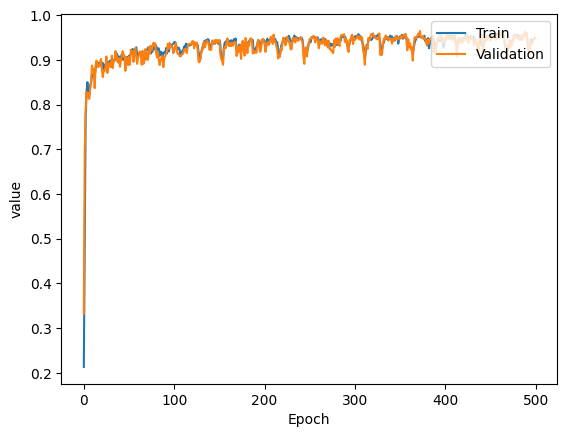

In [95]:
#epoch=100 lr=0.0001 batch=32
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

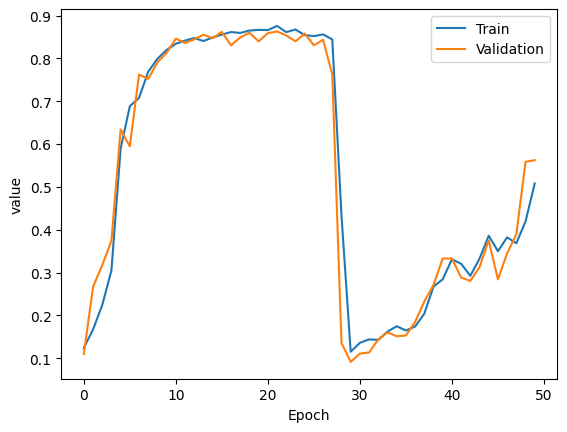

In [80]:
#epoch=50 lr=0.001 batch=32
plt.plot(hist['accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Validation')
plt.ylabel('value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')